<center>
<img src="http://www.bigdive.eu/wp-content/uploads/2012/05/logoBIGDIVE-01.png">
</center>

---

# Classifying Digits

## André Panisson

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


The MNIST dataset contains 70000 images of hand-written digits. Each image is a matrix of 28x28 grayscale pixels. The value of each pixel goes from 0 to 255.

There is more information available in the MNIST dataset repository:
http://yann.lecun.com/exdb/mnist/

Let's first fetch the dataset from the internet (which may take a while, note the asterisk [*]):

In [8]:
from sklearn.datasets import fetch_mldata
digits = fetch_mldata("MNIST Original", data_home='.') # fetch dataset from internet
X_all, y_all = digits['data'], digits['target']
print X_all.shape

(70000, 784)


This dataset is ordered, and we will get just part of it to speed up this exercise.

For this, we need to shuffle the entire data and get the first instances.

In [9]:
from sklearn.utils import shuffle

# shuffle dataset (which is sorted!)
X_all, y_all = shuffle(X_all, y_all, random_state=42)

# take only the first instances, to shorten runtime
X = X_all[:1500]
y = y_all[:1500]

# take the other instances for testing
X_test = X_all[1500:]
y_test = y_all[1500:]

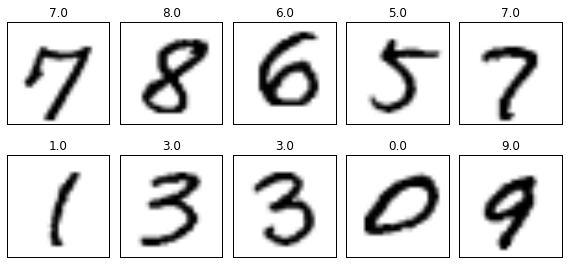

In [10]:
plt.rc("image", cmap="binary")
plt.figure(figsize=(8,4))
for i in xrange(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

From the sklearn documentation:

> Many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

We will then rescale the training data, since this is important to improve the performance of the classification algorithm that we will use later.

In [14]:
# appunti doc su matrice

In [15]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X)
X = scaler.transform(X)

In [17]:
X[0] # i valori sono stati normalizzati e sono tra -1 e 1
# vedi binazrizzazione delle feature

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

PCA (Principal Component Analysis) converts a dataset of possibly correlated features into a dataset of linearly uncorrelated features called principal components. is equivalent to **Singular Value Decomposition** (SVD):

$$\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$$

The value returned from `transform` is in fact the matrix $\mathbf{U}$. The parameter `n_components` is the number of components to keep. if n_components is not set, all components are kept; it means that the result of `transform` is a matrix $n \times n$ (if $d \geq n$) or $n \times d$ (if $d < n$).

The values in the attribute `explained_variance_` are related to $\boldsymbol{\Sigma}$ in the SVD decomposition. Finally, the values in the attribute `components_` are related to $\mathbf{V}^T$.

The optional parameter `whiten=True` make it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

In [18]:
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(X)

U = pca.transform(X)
S = pca.explained_variance_
V = pca.components_

print U.shape
print S.shape
print V.shape

(1500, 784)
(784,)
(784, 784)


It does not make much sense to look at the transformed images, they will look like noise to us.

Instead, let's have a look at the most important directions on which the dataset was projected. These directions can be accessed in the $\mathbf{V}^T$ matrix.

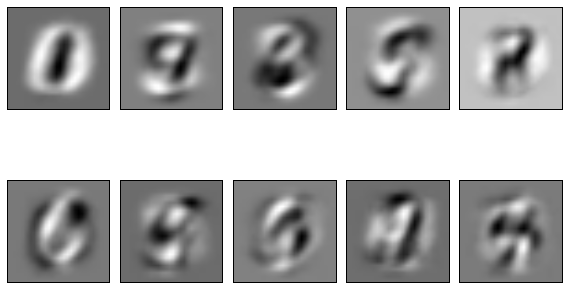

In [19]:
plt.figure(figsize=(8,6))

for i in xrange(10): # loop over all means
    plt.subplot(2,5,i+1)
    plt.imshow(V[i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

The later directions (here, from the 100-th on) show noise and small variations between different, but very similar training instances:

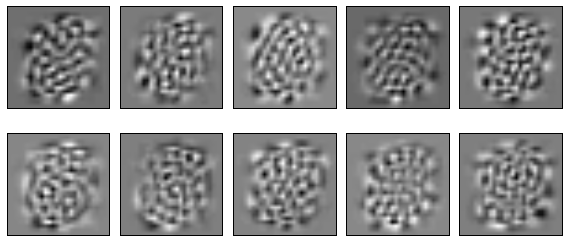

In [21]:
# gli ultimi assi non spiegano pi niente della variabilita'

plt.figure(figsize=(8,4))

for i in xrange(10): # loop over all means
    plt.subplot(2,5,i+1)
    plt.imshow(V[100+i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

The number of "interesting" dimensions can be seen from the importance of the found directions.

We can find this information by plotting the `explained_variance_` attribute from the `PCA` variable. This is related to the $\Sigma$ matrix in the following way:

$$\mathbf{ev} = \frac{1}{N} \Sigma^2 $$

In order to find the most relevant directions, we can use the `explained_variance_` to get 90% of the dataset variance.

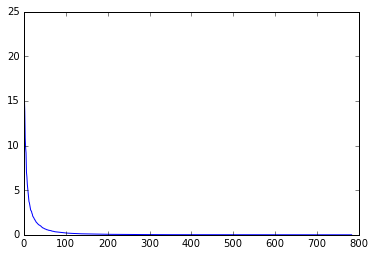

In [22]:
plt.plot(pca.explained_variance_)

81


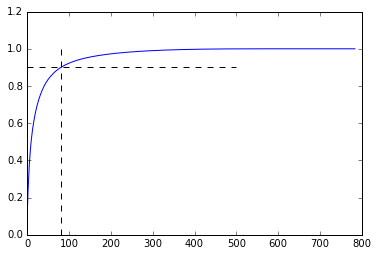

In [26]:
# fermarsi al numero di componenti che arrivano a spiegare il 90 % della variabilita'
ev_cumsum = np.cumsum(pca.explained_variance_)/(pca.explained_variance_).sum()
ev_at90 = ev_cumsum[ev_cumsum<0.90].shape[0]
print ev_at90

plt.plot(ev_cumsum)
plt.vlines(ev_at90, 0, 1, linestyles='dashed')
plt.hlines(0.90, 0, 500, linestyles='dashed');

We can see that the intrinsic dimensionality is not higher than 80, even though the dataset has 784 dimensions.

By setting the parameter `n_components` to $\mathbf{k}$, we limit the number of components to $\mathbf{k}$. At this point, the decomposition is a **Truncated SVD**.

As consequence, the value returned from `transform` is in fact a matrix $\mathbf{U} \in \mathbb{R}^{n \times k}$, where n is the number of samples and k is the number of components. The number of values in the attribute `explained_variance_`, related to $\boldsymbol{\Sigma}$ in the SVD decomposition, is $\mathbf{k}$. Finally, the values in the attribute `components_` are a matrix $\mathbf{V}^T \in \mathbb{R}^{k \times m}$, where $m$ is the number of features.

In [27]:
from sklearn.decomposition import PCA
pca = PCA(80)

pca.fit(X)

U = pca.transform(X)
S = pca.explained_variance_
V = pca.components_


# la matrice U ha tutte la feature indipendenti
print U.shape
print S.shape
print V.shape

(1500, 80)
(80,)
(80, 784)


## Exercise

From now on, we will try to train a SVM classificator to classify the numbers.

For this, create a SVM classifier with **rbf** kernel and default parameters and assign it to a variable with name **`svm`**.
Then, create a list named **`gammas`** with 10 values for the rbf coefficient (gamma) starting from $10^{-4}$ to $10^{0}$, spaced evenly on a log scale. For each value of gamma, set the model parameter **`gamma`** to this value, calculate a list of 3-fold cross-validation scores, and add the average score to a list with name **`scores`**. Use **`X`** and **`y`** to train the model.

Finally, plot the score for each gamma value.

Make note of the time that it takes to search for the best gamma.

Best gamma: 0.00599484250319
Best score: 0.916643795361
CPU times: user 1min 10s, sys: 36 ms, total: 1min 10s
Wall time: 1min 11s


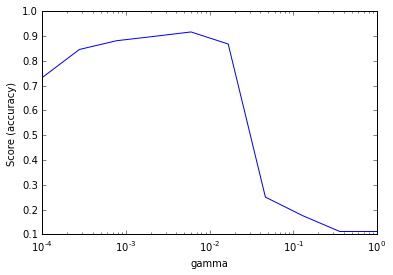

In [54]:
%%time

from sklearn import svm, cross_validation, grid_search, metrics

model = svm.SVC(kernel='rbf', gamma=1e-1)

gammas = np.logspace(-4, 0, 10)

scores = []
acc=metrics.accuracy_score

for gamma in gammas:
    model = svm.SVC(kernel='rbf', gamma=gamma)
    score = cross_validation.cross_val_score(model, X, y, cv=3) # 2/3 dei dati per fare training, 1/3 per fare test
    scores.append(np.mean(score))

print 'Best gamma:', gammas[np.argmax(scores)]
print 'Best score:', scores[np.argmax(scores)]

semilogx(gammas, scores)
plt.xlabel('gamma')
plt.ylabel('Score (accuracy)')
# la scelta migliore e' il punto piu' alto della curva ed esplorare meglio l'area intorno a quel valore di gamma

Check the score of the best model in the test set.

In [56]:
classifier = svm.SVC(kernel='rbf', gamma=gammas[np.argmax(scores)])
classifier.fit(X, y) # fare train con tutti i dati e non solo 2/3 permette di migliorare ancora lo score

X_test_norm = scaler.transform(X_test) # il test set  va trasformato come il train set
print classifier.score(X_test_norm, y_test)

0.0999416058394


In the next exercise, reduce the **`X`** data to a matrix **`U`** using PCA with 80 components.

Next, reproduce exactly the same steps as the previous exercise, but use **`U`** instead of **`X`** to train the model.

Make note of the time that it takes to search for the best gamma.

In [66]:
%%time

from sklearn import svm, cross_validation

model = svm.SVC(kernel='rbf')
gammas = np.logspace(-4, 0, 10)
scores = []

from sklearn.decomposition import PCA
pca = PCA(80)

pca.fit(X)

U = pca.transform(X)


for gamma in gammas:
    model.gamma = gamma
    scores.append(np.mean(cross_validation.cross_val_score(model, U, y, cv = 3)))

CPU times: user 13 s, sys: 56 ms, total: 13.1 s
Wall time: 12.4 s


Best gamma: 0.00599484250319
Best score: 0.919974525795


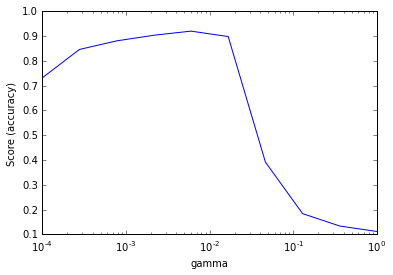

In [67]:
print 'Best gamma:', gammas[np.argmax(scores)]
print 'Best score:', scores[np.argmax(scores)]

semilogx(gammas, scores)
plt.xlabel('gamma')
plt.ylabel('Score (accuracy)')

Check the score of the best model that uses PCA in the test set.

In [68]:
classifier = svm.SVC(kernel='rbf', gamma=gammas[np.argmax(scores)])
classifier.fit(U, y)

X_test_norm = scaler.transform(X_test)

U_test = pca.transform(X_test_norm)

print classifier.score(U_test, y_test)

0.0988467153285


Finally, find the best value also for the C parameter and check its score in the test set.

In [69]:
# YOUR CODE HERE
# fare dei cicli prima su gamma, poi su C poi per la copia di valori trovare il miglior score
# Cerca Randomized Parameter Optimization